## Charge libraries

In [16]:
library(tidyverse)
library(magrittr)
library(ggpubr)
library(VennDiagram)

## Load meteor and sylph data¶

In [25]:
meteor <- read_csv("../data/meteor.csv", show_col_types = FALSE) # meteor data
sylph <- read_csv("../data/sylph.csv", show_col_types = FALSE) # sylph data
sylph %<>% filter(stringr::str_count(clade_name, "\\|") == 7) # keep fines level of detection in sylph (strain level)

## Estimate per-sample taxon presence at the finest taxonomic resolution (strain level in sylph, MSP level in meteor)

In [4]:
suppressWarnings(
  meteor %>% select(-(clade_name:species)) %>%            # Remove taxonomy  columns
  summarise(across(everything(), ~ sum(. > 0))) %>%     # Count non-zero values per column
  pivot_longer(everything(), names_to = "sample", values_to = "richness") %>% 
  separate(sample, c("sample", "rarefaction"), sep = "_", extra = "merge")  %>%
  select(sample, richness, rarefaction) %>%
  mutate(method = "meteor") -> richness
)

In [5]:
suppressWarnings(
sylph %>% select(-clade_name) %>%                   # Remove clade names
  summarise(across(everything(), ~ sum(. > 0))) %>% # Count non-zero values per sample
  pivot_longer(everything(), names_to = "sample", values_to = "richness") %>%
  separate(sample, c("sample", "rarefaction"), sep = "_", extra = "merge")  %>%
  select(sample, richness, rarefaction) %>%
  mutate(method = "sylph") %>%
  rbind(richness) -> richness
    )

## Richness graph

In [6]:
# Transform to plot
richness %<>% mutate(rarefaction = case_when(is.na(rarefaction) ~ "no_rarefaction", TRUE~ rarefaction)) %>%
             mutate(group = case_when(grepl("ASAL",sample) ~ "ASAL", TRUE ~ "miG")) %>%
             mutate(rarefaction = factor(rarefaction, levels = c("no_rarefaction", "1_6"))) %>%
             mutate(pool =  case_when(grepl("ASAL01(5|8)", sample) ~ "pool1",
             grepl("ASAL01(6|9)", sample) ~ "pool2",
             grepl("ASAL0(17|20)", sample) ~ "pool3", TRUE ~ "non_pooled"))

In [1]:
options(repr.plot.width=10, repr.plot.height=10)
set.seed(123)
richness %>% ggplot(aes(x = group, y = richness, fill = group)) +
             geom_boxplot(outlier.shape = NA, alpha = 0.7) +
             geom_jitter(aes(color = pool), width = 0.2, alpha = 0.4, size = 3) +
             facet_grid(rarefaction ~ method) +
             stat_compare_means(method = "wilcox", 
                                method.args = list(exact = FALSE, correct = TRUE),
                                label = "p.signif",
                                 comparisons = list(c("ASAL", "miG"))
                               ) +
             theme_pubr(base_size = 25) +
               labs(
                 x = "Group",
                 y = "Species Richness"
               )

ERROR: Error in richness %>% ggplot(aes(x = group, y = richness, fill = pool)): could not find function "%>%"


## Venn diagrams 

### Meteor rarefied

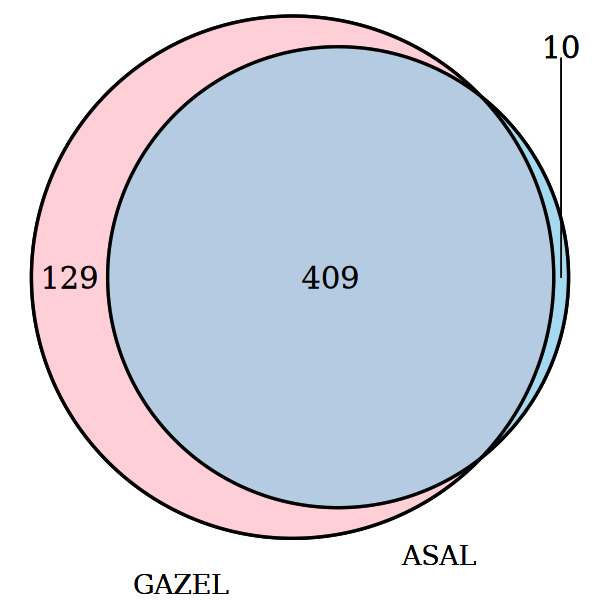

In [28]:
options(repr.plot.width=5, repr.plot.height=5)
# venn diagram
meteor %>% select(clade_name,matches("1_6")) -> df
# 1. Separate ASAL and GAZEL columns
asal_cols <- grep("^ASAL", names(df), value = TRUE)
gazel_cols <- grep("^G[0-9]", names(df), value = TRUE)

# 2. Find present species in ASAL (any non-zero)
asal_species <- df %>%
  filter(if_any(all_of(asal_cols), ~ . > 0)) %>%
  pull(clade_name)

# 3. Find present species in GAZEL (any non-zero)
gazel_species <- df %>%
  filter(if_any(all_of(gazel_cols), ~ . > 0)) %>%
  pull(clade_name)

# 4. Venn Diagram
venn.plot <- draw.pairwise.venn(
  area1 = length(asal_species),
  area2 = length(gazel_species),
  cross.area = length(intersect(asal_species, gazel_species)),
  category = c("ASAL", "GAZEL"),
  fill = c("skyblue", "pink"),
  alpha = c(0.5, 0.5),
  cat.cex = 1.3,
  cex = 1.5,
  cat.pos = c(-20, 20),
  cat.dist = 0.05
)

# Display
grid::grid.draw(venn.plot)

### Meteor non rarefied

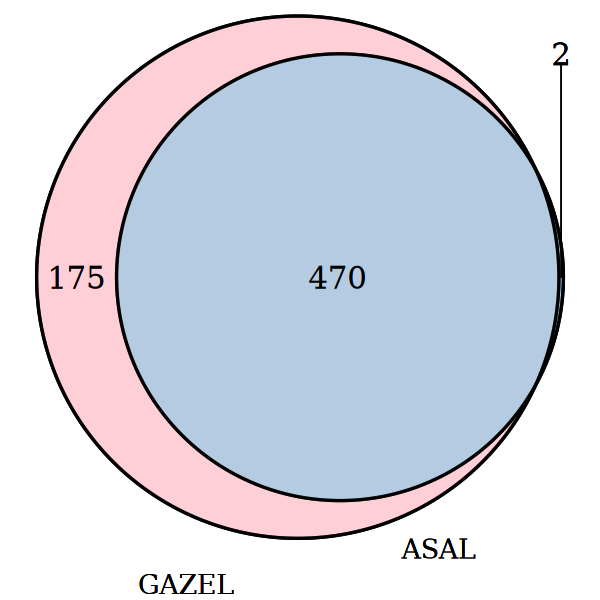

In [29]:
options(repr.plot.width=5, repr.plot.height=5)
# venn diagram
meteor %>% select(clade_name, matches("^ASAL[0-9]+$|^G[0-9]+$")) -> df
#meteor %>% select(clade_name,matches("1_6")) -> df_n
# 1. Separate ASAL and GAZEL columns
asal_cols <- grep("^ASAL", names(df), value = TRUE)
gazel_cols <- grep("^G[0-9]", names(df), value = TRUE)

# 2. Find present species in ASAL (any non-zero)
asal_species <- df %>%
  filter(if_any(all_of(asal_cols), ~ . > 0)) %>%
  pull(clade_name)

# 3. Find present species in GAZEL (any non-zero)
gazel_species <- df %>%
  filter(if_any(all_of(gazel_cols), ~ . > 0)) %>%
  pull(clade_name)

# 4. Venn Diagram
venn.plot <- draw.pairwise.venn(
  area1 = length(asal_species),
  area2 = length(gazel_species),
  cross.area = length(intersect(asal_species, gazel_species)),
  category = c("ASAL", "GAZEL"),
  fill = c("skyblue", "pink"),
  alpha = c(0.5, 0.5),
  cat.cex = 1.3,
  cex = 1.5,
  cat.pos = c(-20, 20),
  cat.dist = 0.05
)

# Display
grid::grid.draw(venn.plot)

### Sylph  rarefied

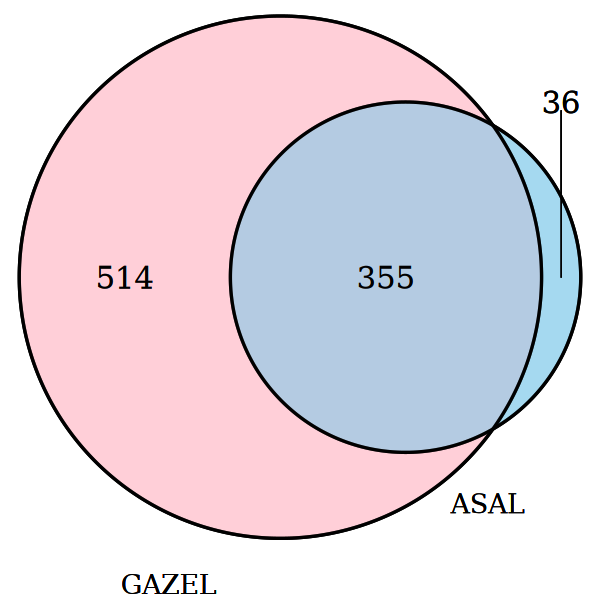

In [30]:
options(repr.plot.width=5, repr.plot.height=5)
# venn diagram
sylph %>% select(clade_name,matches("1_6")) -> df
# 1. Separate ASAL and GAZEL columns
asal_cols <- grep("^ASAL", names(df), value = TRUE)
gazel_cols <- grep("^G[0-9]", names(df), value = TRUE)

# 2. Find present species in ASAL (any non-zero)
asal_species <- df %>%
  filter(if_any(all_of(asal_cols), ~ . > 0)) %>%
  pull(clade_name)

# 3. Find present species in GAZEL (any non-zero)
gazel_species <- df %>%
  filter(if_any(all_of(gazel_cols), ~ . > 0)) %>%
  pull(clade_name)

# 4. Venn Diagram
venn.plot <- draw.pairwise.venn(
  area1 = length(asal_species),
  area2 = length(gazel_species),
  cross.area = length(intersect(asal_species, gazel_species)),
  category = c("ASAL", "GAZEL"),
  fill = c("skyblue", "pink"),
  alpha = c(0.5, 0.5),
  cat.cex = 1.3,
  cex = 1.5,
  cat.pos = c(-20, 20),
  cat.dist = 0.05
)

# Display
grid::grid.draw(venn.plot)

### Sylph  non-rarefied

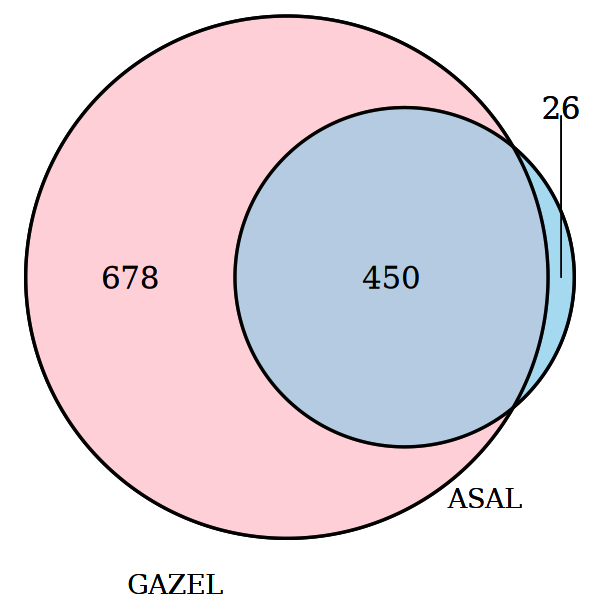

In [31]:
options(repr.plot.width=5, repr.plot.height=5)
# venn diagram
sylph %>% select(clade_name, matches("^ASAL[0-9]+$|^G[0-9]+$")) -> df
# 1. Separate ASAL and GAZEL columns
asal_cols <- grep("^ASAL", names(df), value = TRUE)
gazel_cols <- grep("^G[0-9]", names(df), value = TRUE)

# 2. Find present species in ASAL (any non-zero)
asal_species <- df %>%
  filter(if_any(all_of(asal_cols), ~ . > 0)) %>%
  pull(clade_name)

# 3. Find present species in GAZEL (any non-zero)
gazel_species <- df %>%
  filter(if_any(all_of(gazel_cols), ~ . > 0)) %>%
  pull(clade_name)

# 4. Venn Diagram
venn.plot <- draw.pairwise.venn(
  area1 = length(asal_species),
  area2 = length(gazel_species),
  cross.area = length(intersect(asal_species, gazel_species)),
  category = c("ASAL", "GAZEL"),
  fill = c("skyblue", "pink"),
  alpha = c(0.5, 0.5),
  cat.cex = 1.3,
  cex = 1.5,
  cat.pos = c(-20, 20),
  cat.dist = 0.05
)

# Display
grid::grid.draw(venn.plot)